In [25]:
import pandas as pd

In [26]:
import numpy as np

In [88]:
path = "Dataset/SG_car_cleaned.csv"

In [89]:
data = pd.read_csv(path)

In [90]:
data = data.drop(['Unnamed: 0','Unnamed: 0.1','trj_id', 'osname', 'pingtimestamp', 'timestamp', 'latitude', 'longitude', 'speed', 'bearing', 'accuracy', 'pickup_time', 'dropoff_time','is_weekend','is_weekday','pickup_pca0','pickup_pca1','dropoff_pca0','dropoff_pca1'], axis=1)

In [91]:
data

,travel_time,latitude_origin,longitude_origin,latitude_destination,longitude_destination,hour_of_day,day_of_week,is_wee_hours,is_rush_hours_morning,is_rush_hours_evening,sin_hour_of_day,cos_hour_of_day,sin_day_of_week,cos_day_of_week,haversine_km,haversine_m
0,1520.0,1.270377,103.857875,1.446609,103.806354,2,1,0,0,0,5.000000e-01,0.866025,0.781831,0.623490,20.403093,12.677028
1,1158.0,1.282591,103.851082,1.332855,103.977278,8,4,0,0,0,8.660254e-01,-0.500000,-0.433884,-0.900969,15.091547,9.376812
2,1366.0,1.355363,103.863157,1.343218,103.858504,10,5,0,0,1,5.000000e-01,-0.866025,-0.974928,-0.222521,1.445192,0.897939
3,1328.0,1.340301,103.775742,1.303071,103.900220,1,5,0,0,0,2.588190e-01,0.965926,-0.974928,-0.222521,14.434456,8.968542
4,1210.0,1.333936,103.953225,1.309601,103.833983,7,3,0,0,0,9.659258e-01,-0.258819,0.433884,-0.900969,13.520439,8.400637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27537,1112.0,1.396872,103.747718,1.319548,103.843496,22,0,0,0,0,-5.000000e-01,0.866025,0.000000,1.000000,13.676692,8.497722
27538,983.0,1.396533,103.747537,1.322236,103.841737,22,1,0,0,0,-5.000000e-01,0.866025,0.781831,0.623490,13.329784,8.282178
27539,1382.0,1.301317,103.899443,1.410657,103.778843,1,6,0,0,0,2.588190e-01,0.965926,-0.781831,0.623490,18.086938,11.237934
27540,1212.0,1.298612,103.853801,1.341311,103.981728,11,2,0,0,1,2.588190e-01,-0.965926,0.974928,-0.222521,14.983214,9.309501


#Modelling

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
data = data.sample(frac=1).reset_index(drop=True)
train, test = train_test_split(data, test_size=0.3, train_size = 0.7)
validate, test = train_test_split(test, test_size = 0.3, train_size = 0.7)
print(len(train))
print(len(validate))
print(len(test))

19279
5784
2479


In [34]:
from sklearn import preprocessing

In [35]:
#train_scaled = preprocessing.scale(train[train.columns.difference(['travel_time'])])
X_train = train[train.columns.difference(['travel_time'])]
Y_train = train["travel_time"]
#val_scaled = preprocessing.scale(validate[validate.columns.difference(['travel_time'])])
X_val = validate[validate.columns.difference(['travel_time'])]
Y_val = validate["travel_time"]
#test_scaled = preprocessing.scale(test[test.columns.difference(['travel_time'])])
X_test = test[test.columns.difference(['travel_time'])]
Y_test = test["travel_time"]

In [36]:
X_train1 = X_train.drop(['pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1'], axis=1)
X_val1 = X_val.drop(['pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1'], axis=1)
X_test1 = X_test.drop(['pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1'], axis=1)

In [37]:
X_train1 = X_train1.drop(['is_weekday','is_weekend'], axis=1)
X_val1 = X_val1.drop(['is_weekday','is_weekend'], axis=1)
X_test1 = X_test1.drop(['is_weekday','is_weekend'], axis=1)

In [38]:
import timeit
"""start = timeit.default_timer()
main()
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))"""

'start = timeit.default_timer()\nmain()\nend = timeit.default_timer()\nprint("Time taken in seconds:{}".format(end-start))'

#XGBoost

In [78]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train1, label=Y_train)
dvalid = xgb.DMatrix(X_val1, label=Y_val)
dtest = xgb.DMatrix(X_test1)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [79]:
start = timeit.default_timer()
evaluation_results = dict()
xgb_pars = {'min_child_weight': 50, 'eta': 0.005 ,'colsample_bytree': 0.9, 
            'max_depth': 10,
'subsample': 0.1, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:squarederror'}
model = xgb.train(xgb_pars, dtrain, 2500, watchlist, early_stopping_rounds=40,
      maximize=False, verbose_eval=1, evals_result = evaluation_results)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))
print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:1251.07	valid-rmse:1250.47
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 40 rounds.
[1]	train-rmse:1245.07	valid-rmse:1244.45
[2]	train-rmse:1239.04	valid-rmse:1238.41
[3]	train-rmse:1233.09	valid-rmse:1232.43
[4]	train-rmse:1227.15	valid-rmse:1226.49
[5]	train-rmse:1221.27	valid-rmse:1220.59
[6]	train-rmse:1215.39	valid-rmse:1214.69
[7]	train-rmse:1209.6	valid-rmse:1208.89
[8]	train-rmse:1203.79	valid-rmse:1203.08
[9]	train-rmse:1198.02	valid-rmse:1197.29
[10]	train-rmse:1192.3	valid-rmse:1191.56
[11]	train-rmse:1186.6	valid-rmse:1185.85
[12]	train-rmse:1181.02	valid-rmse:1180.24
[13]	train-rmse:1175.38	valid-rmse:1174.59
[14]	train-rmse:1169.76	valid-rmse:1168.95
[15]	train-rmse:1164.14	valid-rmse:1163.32
[16]	train-rmse:1158.56	valid-rmse:1157.73
[17]	train-rmse:1153.01	valid-rmse:1152.16
[18]	train-rmse:1147.48	valid-rmse:1146.62
[19]	train-rmse:1141.99	valid-rmse:1141.11
[20]	tra

In [81]:
ypred1 = model.predict(dtest)
mse = mean_squared_error(Y_test,ypred1)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 201.73


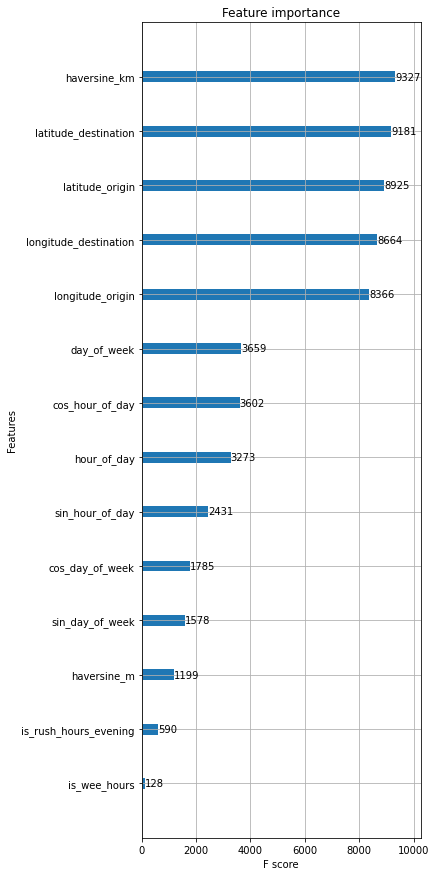

In [82]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 15)
xgb.plot_importance(booster=model)

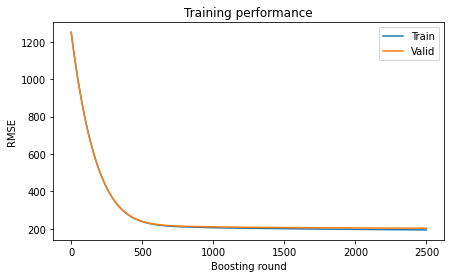

In [83]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=[7, 4])

# Plot the log loss during training
axs.plot(evaluation_results['train']['rmse'], label='Train')
axs.plot(evaluation_results['valid']['rmse'], label='Valid')
axs.set_ylabel('RMSE')
axs.set_xlabel('Boosting round')
axs.set_title('Training performance')
axs.legend()

plt.show()

In [84]:
model.save_model('xgb_really_final.pkl')

In [85]:
bst = xgb.Booster({'nthread': -1})  # init model
bst.load_model('xgb_really_final.pkl')  # load data

In [86]:
gg = bst.predict(dtest)
mse = mean_squared_error(Y_test,gg)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 201.73


In [ ]:
import joblib
# save model
joblib.dump(model, '/content/drive/My Drive/Hackhathon 2020 Shared Drive/model/xgbIvan.pkl')

['/content/drive/My Drive/Hackhathon 2020 Shared Drive/model/xgbIvan.pkl']

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

#LightGBM (DART)

In [39]:
import lightgbm as lgb

In [40]:
d_train = lgb.Dataset(X_train1, label=Y_train)
d_valid = lgb.Dataset(X_val1, label=Y_val)

In [ ]:
start = timeit.default_timer()

evaluation_results = {}
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.9
params['num_leaves'] = 3
params['min_data'] = 20
params['max_depth'] = 10
params['max_bin'] = 13
params['bagging_fraction']= 0.9
clf = lgb.train(params, d_train, valid_sets=[d_train, d_valid],
                num_boost_round = 50000,valid_names=['Train', 'Valid'],
                evals_result = evaluation_results, early_stopping_rounds = 40)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

In [46]:
y_pred2 = clf.predict(X_test1)
mse = mean_squared_error(Y_test,y_pred2)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 208.99


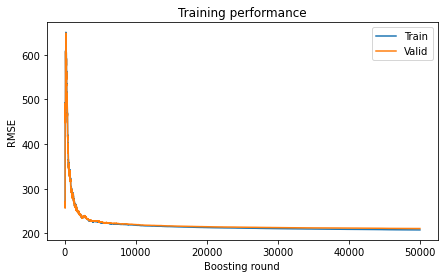

In [47]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=[7, 4])

# Plot the log loss during training
axs.plot(evaluation_results['Train']['rmse'], label='Train')
axs.plot(evaluation_results['Valid']['rmse'], label='Valid')
axs.set_ylabel('RMSE')
axs.set_xlabel('Boosting round')
axs.set_title('Training performance')
axs.legend()

plt.show()

In [48]:
import joblib
# save model
joblib.dump(clf, 'dart_final.pkl')

['dart_final.pkl']

In [49]:
loaded_model = joblib.load('dart_final.pkl')

y_pred2 = loaded_model.predict(X_test1)
mse = mean_squared_error(Y_test,y_pred2)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 208.99


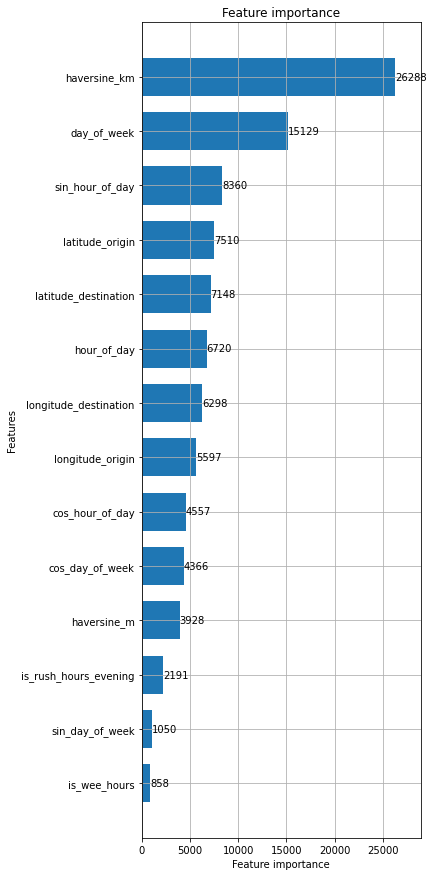

In [50]:
lgb.plot_importance(clf, max_num_features=51, height=0.7, figsize=(5,15))

## LightGBM (GBDT)

In [76]:
start = timeit.default_timer()

evaluation_results = {}
params = {}
params['learning_rate'] = 0.0075
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.9
params['num_leaves'] = 3
params['min_data'] = 20
params['max_depth'] = 10
params['max_bin'] = 15
params['bagging_fraction']= 0.9
clf = lgb.train(params, d_train, valid_sets=[d_train, d_valid],
                num_boost_round = 20000,valid_names=['Train', 'Valid'],
                evals_result = evaluation_results, early_stopping_rounds = 40)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Streaming output truncated to the last 5000 lines.
[5005]	Train's rmse: 213.741	Valid's rmse: 215.612
[5006]	Train's rmse: 213.74	Valid's rmse: 215.61
[5007]	Train's rmse: 213.739	Valid's rmse: 215.609
[5008]	Train's rmse: 213.738	Valid's rmse: 215.607
[5009]	Train's rmse: 213.737	Valid's rmse: 215.606
[5010]	Train's rmse: 213.735	Valid's rmse: 215.605
[5011]	Train's rmse: 213.735	Valid's rmse: 215.605
[5012]	Train's rmse: 213.734	Valid's rmse: 215.605
[5013]	Train's rmse: 213.733	Valid's rmse: 215.605
[5014]	Train's rmse: 213.732	Valid's rmse: 215.603
[5015]	Train's rmse: 213.731	Valid's rmse: 215.602
[5016]	Train's rmse: 213.73	Valid's rmse: 215.601
[5017]	Train's rmse: 213.729	Valid's rmse: 215.601
[5018]	Train's rmse: 213.728	Valid's rmse: 215.6
[5019]	Train's rmse: 213.728	Valid's rmse: 215.6
[5020]	Train's rmse: 213.727	Valid's rmse: 215.599
[5021]	Train's rmse: 213.726	Valid's rmse: 215.598
[5022]	Train's rmse: 213.725	Valid's rmse: 215.596
[5023]	Train's rmse: 213.724	Valid's r

In [77]:
y_pred3 = clf.predict(X_test1)
mse = mean_squared_error(Y_test,y_pred3)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 209.42


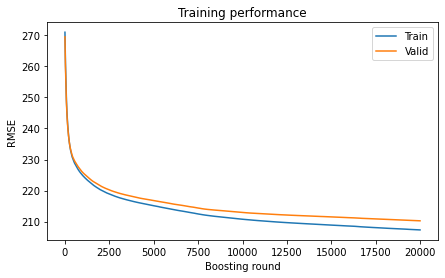

In [73]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=[7, 4])

# Plot the log loss during training
axs.plot(evaluation_results['Train']['rmse'], label='Train')
axs.plot(evaluation_results['Valid']['rmse'], label='Valid')
axs.set_ylabel('RMSE')
axs.set_xlabel('Boosting round')
axs.set_title('Training performance')
axs.legend()

plt.show()

In [74]:
joblib.dump(clf, 'lgb_really_final.pkl')

['lgb_really_final.pkl']

In [75]:
loaded_model = joblib.load('lgb_really_final.pkl')

y_pred3 = loaded_model.predict(X_test1)
mse = mean_squared_error(Y_test,y_pred3)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 207.96


#Catboost

In [ ]:
pip install catboost==0.7.2

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
mode = CatBoostRegressor(iterations=2800,
                          learning_rate=0.01,
                          task_type = "CPU",
                          depth=5,
                         od_type = 'Iter',
                         od_wait=40)
# Fit model
mode.fit(X_train, Y_train,eval_set=(X_val, Y_val))


0:	learn: 1243.6631004	test: 1247.9043916	best: 1247.9043916 (0)	total: 17.5ms	remaining: 49s
1:	learn: 1231.7046216	test: 1235.9463765	best: 1235.9463765 (1)	total: 34.3ms	remaining: 48s
2:	learn: 1219.9846929	test: 1224.2310003	best: 1224.2310003 (2)	total: 51.7ms	remaining: 48.2s
3:	learn: 1208.3412724	test: 1212.6124947	best: 1212.6124947 (3)	total: 69.3ms	remaining: 48.4s
4:	learn: 1196.7979598	test: 1201.0923279	best: 1201.0923279 (4)	total: 85.9ms	remaining: 48s
5:	learn: 1185.3876958	test: 1189.6905837	best: 1189.6905837 (5)	total: 103ms	remaining: 47.8s
6:	learn: 1174.1271439	test: 1178.4323060	best: 1178.4323060 (6)	total: 120ms	remaining: 48s
7:	learn: 1162.9680203	test: 1167.3051482	best: 1167.3051482 (7)	total: 138ms	remaining: 48s
8:	learn: 1151.9072088	test: 1156.2439851	best: 1156.2439851 (8)	total: 158ms	remaining: 49.1s
9:	learn: 1140.9432052	test: 1145.3034917	best: 1145.3034917 (9)	total: 172ms	remaining: 48.1s
10:	learn: 1130.1160555	test: 1134.4831437	best: 1134.4

In [ ]:
# Get predictions
y_pred3 = mode.predict(X_test)
mse = mean_squared_error(Y_test,y_pred3)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 202.61
